In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.3 MB/s eta 0:00:00


In [ ]:
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=a1ba9d0c337ecf5e7b0c555d8256b58a80bc52ef38e4436da041ef275b9f9b30
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops


In [ ]:
import time
import torch
import torchmetrics
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch.utils.data import random_split
from torch.autograd import Variable
from matplotlib import pyplot as plt
import pandas as pd
from ptflops import get_model_complexity_info



#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
Tesla T4
cuda


## Import Data

In [ ]:
#import Fashion MNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform= torchvision.transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform= torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
batch_size = 64

# Create the data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(testset, batch_size=batch_size, shuffle = False)
#val_loader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
#test_loader = DataLoader(testset, batch_size=batch_size, shuffle = False)

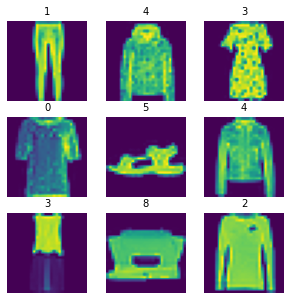

In [ ]:
#visualize a few images from the data loader
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i][0])
    ax.set_title(labels[i].item(), fontsize=10)
    ax.axis('off')

plt.show()

## Define Training Loop and Original Model

In [ ]:
#define training fucntion
def train(model, train_loader, val_loader, num_epochs, optimizer, criterion):
  count = 0
  for epoch in range(num_epochs):
      for images, labels in train_loader:
          model.train()

          # Forward pass 
          outputs = model(images)
          labels = torch.eye(10)[labels]
          train_loss = criterion(outputs, labels)

          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()    
          # Propagating the error backward
          train_loss.backward()
          # Optimizing the parameters
          optimizer.step()

          # calculate the accuracy
          accuracy.update(outputs, labels)
          
      final_accuracy_train = accuracy.compute()         
      train_accuracy_list.append(final_accuracy_train)
      train_loss_list.append(train_loss)

      for images, labels in val_loader:
          model.eval()
          labels = torch.eye(10)[labels]
          # Forward pass 
          with torch.no_grad():
            outputs = model(images)
          loss_val = criterion(outputs, labels)

          #calculate the accuracy
          accuracy.update(outputs, labels)

      final_accuracy_val = accuracy.compute()    
      val_accuracy_list.append(final_accuracy_val)
      val_loss_list.append(loss_val)
      print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}, Train Acc: {final_accuracy_train}, ValidationLoss: {loss_val}, Validation Acc: {final_accuracy_val}')     
      accuracy.reset()

In [ ]:
#define Lenet class that has the textbooks 
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = nn.Sequential(
              nn.Conv2d(1, 6, kernel_size=5, padding=2), 
              nn.Sigmoid(),
              nn.AvgPool2d(kernel_size=2, stride=2),
              nn.Conv2d(6, 16, kernel_size=5), 
              nn.Sigmoid(),
              nn.AvgPool2d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(16 * 5 * 5, 120), 
              nn.Sigmoid(),
              nn.Linear(120, 84), 
              nn.Sigmoid(),
              nn.Linear(84, num_classes))
    
  def forward(self, x):
      x = self.net(x)
      return x

## Problem 1
The base model from the textbook was updated where average pooling layers were replaced with max pooling layers as well as all sigmoid activation fucntions replaced with ReLU functions.
The Final training accuracy seen after 20 epcohs is 61.5% which also happens to be the validation accuracy. The training loss was 0.51 after 20 epochs as well. 
Compared to the baseline model from the textbook this model performed worst in some ways. The first is the flunctuation in the training loss. The final accuracies in the textbook also seemed ot be better but not significatly, perhaps 70% (based on graph in textbook).

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

print(model)
macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
Computational complexity:       435.85 KMac
Number of parameters:           61.71 k 


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 1.847108006477356, Train Acc: 0.6879783272743225, ValidationLoss: 1.8805023431777954, Validation Acc: 0.6766871213912964
Epoch [2/20], Loss: 1.2071459293365479, Train Acc: 0.6225600242614746, ValidationLoss: 1.0682454109191895, Validation Acc: 0.6235271692276001
Epoch [3/20], Loss: 0.9769051671028137, Train Acc: 0.6314799785614014, ValidationLoss: 0.8186323642730713, Validation Acc: 0.631428599357605
Epoch [4/20], Loss: 0.8107662200927734, Train Acc: 0.6321349740028381, ValidationLoss: 0.6885690689086914, Validation Acc: 0.6317800283432007
Epoch [5/20], Loss: 1.3333003520965576, Train Acc: 0.6285250186920166, ValidationLoss: 0.635277509689331, Validation Acc: 0.628257155418396
Epoch [6/20], Loss: 0.7304664254188538, Train Acc: 0.624501645565033, ValidationLoss: 0.5933657884597778, Validation Acc: 0.6241557002067566
Epoch [7/20], Loss: 0.6945375204086304, Train Acc: 0.6215783357620239, ValidationLoss: 0.579192578792572, Validation Acc: 0.6213928461074829
Epoch [8/20]

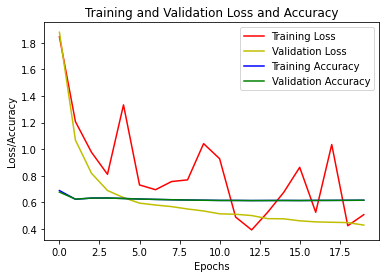

In [ ]:
Trainlosses= [ loss.detach().numpy() for loss in train_loss_list]
vallosses= [ loss.detach().numpy() for loss in val_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2_1 - Adjust the convolution window size.
The model from problem one is used as a base model, and the window size is adjusted to to be 3,3 instead of 2,2. The Final training accuracy seen after 20 epcohs is 63% which also happens to be the validation accuracy. The training loss was 0.45 after 20 epochs as well. Compared to the baseline model from the textbook this model also performed worst in some ways. The flunctuation in the training loss is still present and the final accuracies are lower than that the textbook's. Compared to problem one, this model performed almost the same except that it was able to achieve a relatively smaller trainign loss with the same number of epochs. The Computational complexity for this model is 372.06 KMac and the Number of parameters is 44.43 k.

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
#adjust window size to 3
model.net[2] = nn.MaxPool2d(kernel_size=3, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=3, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

#update model accordingly (dense layers inputs/outputs)
model.net[7] = nn.Linear(256, 120)
model.net[9] = nn.Linear(120, 84)
model.net[11] = nn.Linear(84, 10)

print(model)

macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
Computational complexity:       372.06 KMac
Number of parameters:           44.43 k 


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 2.1845760345458984, Train Acc: 0.5800483226776123, ValidationLoss: 2.2271831035614014, Validation Acc: 0.5828657150268555
Epoch [2/20], Loss: 1.488295078277588, Train Acc: 0.625956654548645, ValidationLoss: 1.524613380432129, Validation Acc: 0.6241271495819092
Epoch [3/20], Loss: 1.2054834365844727, Train Acc: 0.6110316514968872, ValidationLoss: 1.0132173299789429, Validation Acc: 0.611299991607666
Epoch [4/20], Loss: 0.9547830820083618, Train Acc: 0.6155149936676025, ValidationLoss: 0.8080229163169861, Validation Acc: 0.615817129611969
Epoch [5/20], Loss: 0.7493317723274231, Train Acc: 0.6183016896247864, ValidationLoss: 0.6810458898544312, Validation Acc: 0.618455708026886
Epoch [6/20], Loss: 0.8180349469184875, Train Acc: 0.6198816895484924, ValidationLoss: 0.599785566329956, Validation Acc: 0.6200171709060669
Epoch [7/20], Loss: 0.9587066173553467, Train Acc: 0.620764970779419, ValidationLoss: 0.5489935278892517, Validation Acc: 0.620851457118988
Epoch [8/20], L

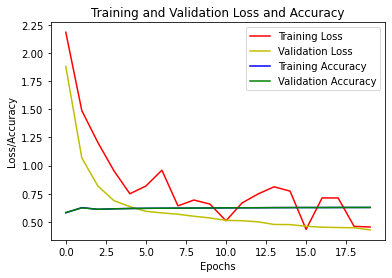

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Probelm 2_2 - Adjust the number of output channels
The model from problem one is used as a base model, and the output channel for the conv layers was increased to 12 and 20. The Final training accuracy seen after 20 epcohs is 59.3% which also happens to be the validation accuracy. The training loss was 0.66 after 20 epochs as well. Compared to the baseline model from the textbook this model also performed worst in some ways. The flunctuation in the training loss is still present and the final accuracies are lower than that the textbook's. Compared to problem one, this model performed almost the same except that it was able to achieve a relatively smaller trainign loss with the same number of epochs. The Computational complexity for this model is 618.55 KMac and the Number of parameters is 61.7 k. As compard to problem 2_1, the complexity of the model has increased as both the paramters and the computational power have increased. The model also perfomred much worse than problem 2_1 where the accuracies are lower and the loss is higher.

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

#Adjust the number of output channels to 
model.net[0].out_channels = 12
model.net[3].out_channels = 20

print(model)

macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)
Computational complexity:       618.55 KMac
Number of parameters:           61.71 k 


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 1.847216248512268, Train Acc: 0.43627333641052246, ValidationLoss: 1.7487367391586304, Validation Acc: 0.4576157033443451
Epoch [2/20], Loss: 1.16075599193573, Train Acc: 0.5955183506011963, ValidationLoss: 0.9238853454589844, Validation Acc: 0.5967214107513428
Epoch [3/20], Loss: 0.8726529479026794, Train Acc: 0.60944002866745, ValidationLoss: 0.718035101890564, Validation Acc: 0.6096385717391968
Epoch [4/20], Loss: 0.7266287803649902, Train Acc: 0.6117550134658813, ValidationLoss: 0.613913893699646, Validation Acc: 0.6113899946212769
Epoch [5/20], Loss: 0.7625823020935059, Train Acc: 0.6087466478347778, ValidationLoss: 0.5717435479164124, Validation Acc: 0.6083442568778992
Epoch [6/20], Loss: 0.6725558042526245, Train Acc: 0.6048449873924255, ValidationLoss: 0.5404298305511475, Validation Acc: 0.6047871708869934
Epoch [7/20], Loss: 0.5430535674095154, Train Acc: 0.6016666889190674, ValidationLoss: 0.5414854884147644, Validation Acc: 0.6013885736465454
Epoch [8/20]

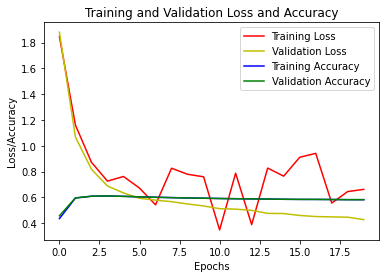

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2_3 - Adjust the number of convolution layers
The model from problem one is used as a base model, and two convolutional layers were added. The Final training accuracy seen after 20 epcohs is 62% which also happens to be the validation accuracy. The training loss was 0.55 after 20 epochs as well. Compared to the baseline model from the textbook this model also performed worst in some ways. The flunctuation in the training loss is still present and the final accuracies are lower than that the textbook's. Compared to problem one, this model performed almost the same except that it was able to achieve a relatively smaller trainign loss with the same number of epochs. The Computational complexity for this model is 2.45 MMac and the Number of parameters is 1.51 M. As compard to problem 2_1, the complexity of the model has increased as both the paramters and the computational power have increased. The model also perfomred almost the same as problem 2_1. As compard to problem 2_1, the complexity of the model has increased as both the paramters and the computational power have increased drastically, which makes sense with the number of convolutional layers increasing. As compared to Problem 2_2, the model performed a little better with slightly higher accuracies and a slightly lower loss. The complxity is still drastically higher than any previous models.

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

# create the two convolutional layers
conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
relu1 = nn.ReLU()
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
relu2 = nn.ReLU()
# insert the new layers after layer [5]
model.net = nn.Sequential(*list(model.net.children())[:6] + [conv1, relu1, conv2, relu2] + list(model.net.children())[6:])

#update model accordingly (dense layers inputs/outputs)
model.net[11] = nn.Linear(1600, 800)
model.net[13] = nn.Linear(800, 256)
model.net[15] = nn.Linear(256, 10)

print(model)

macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1600, out_features=800, bias=True)
    (12): ReLU()
    (13): Linear(in_features=800, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=10, bias=True)
  )
)
Computational complexity:       2.45 MMac
Number of parameters:           1.51 M  


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1600, out_features=800, bias=True)
    (12): ReLU()
    (13): Linear(in_features=800, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 1.3388166427612305, Train Acc: 0.5912816524505615, ValidationLoss: 0.8658483624458313, Validation Acc: 0.593812882900238
Epoch [2/20], Loss: 0.7628452777862549, Train Acc: 0.6072083115577698, ValidationLoss: 0.6659678816795349, Validation Acc: 0.6063228845596313
Epoch [3/20], Loss: 0.8065341711044312, Train Acc: 0.6028516888618469, ValidationLoss: 0.6178520321846008, Validation Acc: 0.6028043031692505
Epoch [4/20], Loss: 0.8368239402770996, Train Acc: 0.6016333103179932, ValidationLoss: 0.6094036102294922, Validation Acc: 0.6015042662620544
Epoch [5/20], Loss: 0.9228541851043701, Train Acc: 0.6018266677856445, ValidationLoss: 0.6003102660179138, Validation Acc: 0.601445734500885
Epoch [6/20], Loss: 0.6463724970817566, Train Acc: 0.6028800010681152, ValidationLoss: 0.5996378660202026, Validation Acc: 0.6029585599899292
Epoch [7/20], Loss: 0.6583418250083923, Train Acc: 0.6041600108146667, ValidationLoss: 0.6091460585594177, Validation Acc: 0.6043242812156677
Epoch [8

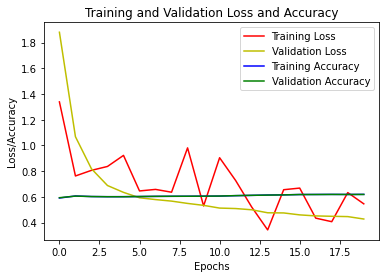

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2_4 - Adjust the number of fully connected layers
The model from problem one is used as a base model, and two cfully connected layers were added a the end of the model's structure. The Final training accuracy seen after 20 epcohs is 96% which also happens to be the validation accuracy. The training loss was 0.15 after 20 epochs as well. Compared to the baseline model from the textbook this model also performed much better. The flunctuation in the training loss is still present but final accuracies are drastically higher. Compared to problem one, this model performed much better. The Computational complexity for this model is 592.85 kMac and the Number of parameters is 218.2 kM. As compard to all previous models, the complexity of the model is relitevley average, its not the lowest but the numbers are not crazy for for such high accuracy it is worth it. The model also perfomred much better than problem 2_1. As compared to Problem 2_2, the model performed much better as well.

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

# create the two convolutional layers
fc1 = nn.Linear(400, 300)
relu1 = nn.ReLU()
fc2 = nn.Linear(300, 200)
relu2 = nn.ReLU()

# insert the new layers after layer [5]
model.net = nn.Sequential(*list(model.net.children())[:7] + [fc1, relu1, fc2, relu2] + list(model.net.children())[7:])

#update model accordingly (dense layers inputs/outputs)
model.net[11] = nn.Linear(200, 120)
model.net[13] = nn.Linear(120, 84)
model.net[15] = nn.Linear(84, 10)

print(model)

macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=300, bias=True)
    (8): ReLU()
    (9): Linear(in_features=300, out_features=200, bias=True)
    (10): ReLU()
    (11): Linear(in_features=200, out_features=120, bias=True)
    (12): ReLU()
    (13): Linear(in_features=120, out_features=84, bias=True)
    (14): ReLU()
    (15): Linear(in_features=84, out_features=10, bias=True)
  )
)
Computational complexity:       592.85 KMac
Number of parameters:           218.21 k


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=300, bias=True)
    (8): ReLU()
    (9): Linear(in_features=300, out_features=200, bias=True)
    (10): ReLU()
    (11): Linear(in_features=200, out_features=120, bias=True)
    (12): ReLU()
    (13): Linear(in_features=120, out_features=84, bias=True)
    (14): ReLU()
    (15): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.8514065146446228, Train Acc: 0.7179533243179321, ValidationLoss: 0.3504648804664612, Validation Acc: 0.7258242964744568
Epoch [2/20], Loss: 0.31407463550567627, Train Acc: 0.7955833077430725, ValidationLoss: 0.5249112844467163, Validation Acc: 0.8008000254631042
Epoch [3/20], Loss: 0.10541705042123795, Train Acc: 0.8387816548347473, ValidationLoss: 0.1983019858598709, Validation Acc: 0.840157151222229
Epoch [4/20], Loss: 0.12694475054740906, Train Acc: 0.8580399751663208, ValidationLoss: 0.31437647342681885, Validation Acc: 0.8613614439964294
Epoch [5/20], Loss: 0.33392709493637085, Train Acc: 0.8767833113670349, ValidationLoss: 0.2970002293586731, Validation Acc: 0.8769599795341492
Epoch [6/20], Loss: 0.24592521786689758, Train Acc: 0.8896833062171936, ValidationLoss: 0.2086239606142044, Validation Acc: 0.8892056941986084
Epoch [7/20], Loss: 0.20238298177719116, Train Acc: 0.8952249884605408, ValidationLoss: 0.40312403440475464, Validation Acc: 0.8961743116378784

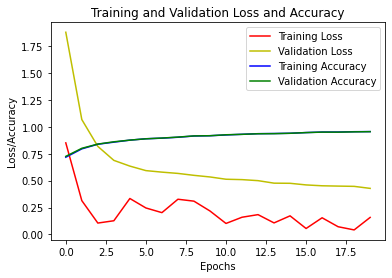

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

## Problem 2_5 - Explore the learning rates
The model from problem one is used as a base model, and various learning rated were tested. a learning rate of .001 achieved the best reulst with the Final training accuracy seen after 20 epcohs is 93% which also happens to be the validation accuracy. The training loss was 0.34 after 20 epochs as well. Compared to the baseline model from the textbook this model also performed much better. The flunctuation in the training loss is still present and can even be considered stronger. Compared to problem one, this model performed much better. The model also perfomred much better than problem 2_1 and 2_2.

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

print(model)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


Test1: lr = 1e-4

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.8661123514175415, Train Acc: 0.617651641368866, ValidationLoss: 0.4292999505996704, Validation Acc: 0.6204185485839844
Epoch [2/20], Loss: 0.730864942073822, Train Acc: 0.6431716680526733, ValidationLoss: 0.3655313551425934, Validation Acc: 0.644681453704834
Epoch [3/20], Loss: 0.45305731892585754, Train Acc: 0.6600533127784729, ValidationLoss: 0.37754255533218384, Validation Acc: 0.659850001335144
Epoch [4/20], Loss: 0.48092299699783325, Train Acc: 0.6808266639709473, ValidationLoss: 0.3361852169036865, Validation Acc: 0.6815528273582458
Epoch [5/20], Loss: 0.5946682095527649, Train Acc: 0.6941050291061401, ValidationLoss: 0.3639536201953888, Validation Acc: 0.6936557292938232
Epoch [6/20], Loss: 0.6283444762229919, Train Acc: 0.7044433355331421, ValidationLoss: 0.31553953886032104, Validation Acc: 0.7041771411895752
Epoch [7/20], Loss: 0.36523330211639404, Train Acc: 0.7100849747657776, ValidationLoss: 0.2828063666820526, Validation Acc: 0.710528552532196
Epoch 

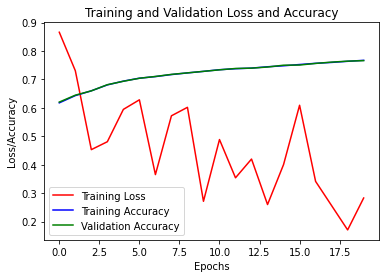

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

Test2: lr = 1e-3

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.14159177243709564, Train Acc: 0.712565004825592, ValidationLoss: 0.2886272966861725, Validation Acc: 0.7210842967033386
Epoch [2/20], Loss: 0.3326442241668701, Train Acc: 0.8065733313560486, ValidationLoss: 0.1496623158454895, Validation Acc: 0.8078057169914246
Epoch [3/20], Loss: 0.20513086020946503, Train Acc: 0.8316649794578552, ValidationLoss: 0.36160746216773987, Validation Acc: 0.8342499732971191
Epoch [4/20], Loss: 0.137930765748024, Train Acc: 0.8423966765403748, ValidationLoss: 0.14605695009231567, Validation Acc: 0.8432071208953857
Epoch [5/20], Loss: 0.20441117882728577, Train Acc: 0.8544466495513916, ValidationLoss: 0.2093639075756073, Validation Acc: 0.8520357012748718
Epoch [6/20], Loss: 0.21647925674915314, Train Acc: 0.8644683361053467, ValidationLoss: 0.20816780626773834, Validation Acc: 0.8644371628761292
Epoch [7/20], Loss: 0.10542398691177368, Train Acc: 0.8741066455841064, ValidationLoss: 0.28228822350502014, Validation Acc: 0.8733371496200562

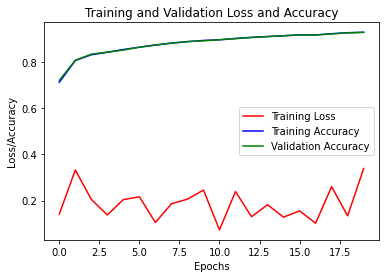

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

Test2: lr = 1e-4

In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.2727639675140381, Train Acc: 0.725380003452301, ValidationLoss: 0.27173537015914917, Validation Acc: 0.7302471399307251
Epoch [2/20], Loss: 0.5125077962875366, Train Acc: 0.766136646270752, ValidationLoss: 0.1919025331735611, Validation Acc: 0.76606285572052
Epoch [3/20], Loss: 0.3489581048488617, Train Acc: 0.7748783230781555, ValidationLoss: 0.21255742013454437, Validation Acc: 0.7745614051818848
Epoch [4/20], Loss: 0.33608412742614746, Train Acc: 0.7811149954795837, ValidationLoss: 0.18819449841976166, Validation Acc: 0.7813614010810852
Epoch [5/20], Loss: 0.16385051608085632, Train Acc: 0.7858200073242188, ValidationLoss: 0.16378438472747803, Validation Acc: 0.7864114046096802
Epoch [6/20], Loss: 0.24569740891456604, Train Acc: 0.7930616736412048, ValidationLoss: 0.23320183157920837, Validation Acc: 0.7927971482276917
Epoch [7/20], Loss: 0.33827751874923706, Train Acc: 0.7974433302879333, ValidationLoss: 0.2201114296913147, Validation Acc: 0.7975000143051147
E

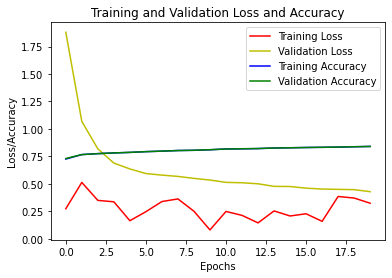

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

# Problem 3 - Add dropout layers to best model from problem two 
The model from problem 2_4 (with added dense layers) had produced the best results with the highest accuracies and lowest losses. Thus this model is chosen as the base for this problem and dropout layers are added. Teh dropout layers did not imporve the results, but rather made the accuracies a little lower (83%) and the loss stayed pretty low, 0.15. Although dropout layers would normally help in geenralization, they perhaps did not have an affect here due to the unnecassry added complecity for a simple dataset such as the Fashion Mnist. 

In [ ]:
#build model off of base model, replacing  average pooling 
#with max-pooling and softmax layer with ReLU
model = LeNet()

#replace avg pooling with max pooling
model.net[2] = nn.MaxPool2d(kernel_size=2, stride=2)
model.net[5] = nn.MaxPool2d(kernel_size=2, stride=2)

#replace softmax with relu
model.net[1] = nn.ReLU()
model.net[4] = nn.ReLU()
model.net[8] = nn.ReLU()
model.net[10] = nn.ReLU()

# create the two convolutional layers
fc1 = nn.Linear(400, 300)
relu1 = nn.ReLU()
drop1 = nn.Dropout(0.3)
fc2 = nn.Linear(300, 200)
relu2 = nn.ReLU()
drop2 = nn.Dropout(0.3)

# insert the new layers after layer [5]
model.net = nn.Sequential(*list(model.net.children())[:7] + [fc1, relu1, drop1, fc2, relu2, drop2] + list(model.net.children())[7:])

#update model accordingly (dense layers inputs/outputs)
model.net[13] = nn.Linear(200, 120)
model.net[15] = nn.Linear(120, 84)
model.net[17] = nn.Linear(84, 10)

print(model)

macs, params = get_model_complexity_info(model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=300, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=300, out_features=200, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=200, out_features=120, bias=True)
    (14): ReLU()
    (15): Linear(in_features=120, out_features=84, bias=True)
    (16): ReLU()
    (17): Linear(in_features=84, out_features=10, bias=True)
  )
)
Computational complexity:       592.85 KMac
Number of parameters:           218.21 k


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=300, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=300, out_features=200, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=200, out_features=120, bias=True)
    (14): ReLU()
    (15): Linear(in_features=120, out_features=84, bias=True)
    (16): ReLU()
    (17): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
train(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.7356351017951965, Train Acc: 0.5832633376121521, ValidationLoss: 0.6378448605537415, Validation Acc: 0.5872942805290222
Epoch [2/20], Loss: 0.8630450367927551, Train Acc: 0.6284616589546204, ValidationLoss: 0.46897873282432556, Validation Acc: 0.6310657262802124
Epoch [3/20], Loss: 0.5202993750572205, Train Acc: 0.6626183390617371, ValidationLoss: 0.3532811105251312, Validation Acc: 0.6649057269096375
Epoch [4/20], Loss: 0.6295534372329712, Train Acc: 0.6875249743461609, ValidationLoss: 0.3674776554107666, Validation Acc: 0.6885671615600586
Epoch [5/20], Loss: 0.7069615125656128, Train Acc: 0.7143700122833252, ValidationLoss: 0.28237345814704895, Validation Acc: 0.7160571217536926
Epoch [6/20], Loss: 0.3049742877483368, Train Acc: 0.7320500016212463, ValidationLoss: 0.28079456090927124, Validation Acc: 0.7334514260292053
Epoch [7/20], Loss: 0.5238062143325806, Train Acc: 0.7510283589363098, ValidationLoss: 0.267362117767334, Validation Acc: 0.7523114085197449
Epoc

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), vallosses, 'y', label='Validation Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()

# Problem 4 - Simplified AlexNet


In [ ]:
#define Lenet class that has the textbooks 
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(96, 256, kernel_size=5, padding=2), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256, 384, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2), 
        nn.Flatten(),
        nn.Linear(256*6*6, 4096), 
        nn.ReLU(), 
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes))
    
  def forward(self, x):
      x = self.net(x)
      return x

In [ ]:
baseAlex = AlexNet()
print(baseAlex)

AlexNet(
  (net): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, out_features=4096, bias=True)
    (18): ReLU()
    (

In [ ]:
#reduce complexity to accomadate for low resolution

baseAlex.net[0] = nn.Conv2d(1, 6, kernel_size=5, padding=2)
baseAlex.net[3] = nn.Conv2d(6, 16, kernel_size=5, padding=2)
baseAlex.net[6] = nn.Conv2d(16, 32, kernel_size=2, padding=2)
del baseAlex.net[8]
del baseAlex.net[8]
del baseAlex.net[8]
del baseAlex.net[8]
del baseAlex.net[8]
del baseAlex.net[5]
del baseAlex.net[5]
del baseAlex.net[5]
baseAlex.net[2] = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
baseAlex.net[6] = nn.Linear(in_features=13456, out_features=600)
baseAlex.net[9] = nn.Linear(in_features=600, out_features=200)
baseAlex.net[12] = nn.Linear(in_features=200, out_features=10)

print(baseAlex)

macs, params = get_model_complexity_info(baseAlex, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

AlexNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=13456, out_features=600, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=600, out_features=200, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=200, out_features=10, bias=True)
  )
)
Computational complexity:       10.37 MMac
Number of parameters:           8.2 M   


In [ ]:
#define params
num_epochs = 20
count = 0

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseAlex.parameters(), lr = 0.0001)
# define the accuracy metric
accuracy = torchmetrics.Accuracy(task='binary')

# Lists for visualization of loss and accuracy 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

In [ ]:
#reset model
# Reset the model's weights
def reset_weights(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

baseAlex.apply(reset_weights)

AlexNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=13456, out_features=600, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=600, out_features=200, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [ ]:
train(baseAlex, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch [1/20], Loss: 0.6205823421478271, Train Acc: 0.7173033356666565, ValidationLoss: 0.2984977960586548, Validation Acc: 0.7247999906539917
Epoch [2/20], Loss: 0.3969118893146515, Train Acc: 0.7680749893188477, ValidationLoss: 0.21457447111606598, Validation Acc: 0.7707328796386719
Epoch [3/20], Loss: 0.2711108326911926, Train Acc: 0.7852150201797485, ValidationLoss: 0.23393963277339935, Validation Acc: 0.7866614460945129
Epoch [4/20], Loss: 0.44960716366767883, Train Acc: 0.7976300120353699, ValidationLoss: 0.20935815572738647, Validation Acc: 0.8000699877738953
Epoch [5/20], Loss: 0.1599985808134079, Train Acc: 0.8084783554077148, ValidationLoss: 0.19799132645130157, Validation Acc: 0.8103271722793579
Epoch [6/20], Loss: 0.21421396732330322, Train Acc: 0.8174816370010376, ValidationLoss: 0.17756344377994537, Validation Acc: 0.8192899823188782
Epoch [7/20], Loss: 0.2590206563472748, Train Acc: 0.8231750130653381, ValidationLoss: 0.17686839401721954, Validation Acc: 0.824704289436340

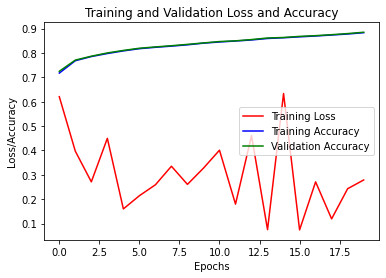

In [ ]:
Trainlosses= [loss.detach().numpy() for loss in train_loss_list]

plt.plot(range(num_epochs), Trainlosses, 'r', label='Training Loss')
plt.plot(range(num_epochs), train_accuracy_list, 'b', label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracy_list, 'g', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.show()